# NOTES

In this file, we create a table containing the detected emission lines and absorption lines.

# Imports

Loading the libraries, files, and spectrums so we can run preliminary anaylsis.

In [4]:
import pandas as pd
import numpy as np
import os

import astropy.units as u

from scipy.optimize import curve_fit
from specutils import Spectrum1D, SpectralRegion
from astropy.io import fits 

from specutils.manipulation import noise_region_uncertainty, extract_region

# ===========================
#          CONSTANTS
# ===========================
u_wavelength = u.Angstrom 
u_flux       = u.erg / (u.s ** 2) / (u.cm ** 2) / u.Angstrom
u_velocity   = u.km / u.second

light_speed  = 299792.458 * u_velocity

In [5]:
hdf5_path = "UltraDeep_Population_Profile.h5"
with pd.HDFStore(hdf5_path, mode='r') as store:
    profile_table = store.get("PopulationProfile")  # Load the DataFrame from the HDF5 file
    print(f"""===== Loaded Table from HDF5 =====
>>> The table has been successfully loaded from '{hdf5_path}' with the key 'PopulationProfile'.""") 

redshift = profile_table['Z'].values
fits_num = profile_table['NUM'].values
zflag = profile_table['ZFLAGS'].values

redshift = redshift[zflag == 4]
fits_num = fits_num[zflag == 4]

===== Loaded Table from HDF5 =====
>>> The table has been successfully loaded from 'UltraDeep_Population_Profile.h5' with the key 'PopulationProfile'.


In [6]:
# ----- Known lines dictionary
known_line = {
    'O VI λ1034': 1033.82,
    'Lyα λ1215': 1215.24,
    'N V λ1241': 1240.81,
    'O I λ1306': 1305.53,
    'C II λ1335': 1335.31,
    'Si IV λ1398': 1397.61,
    'Si IV + O IV λ1400': 1399.8,
    'C IV λ1549': 1549.48,
    'He II λ1640': 1640.4,
    'O III λ1666': 1665.85,
    'Al III λ1857': 1857.4,
    'C III λ1909': 1908.734,
    'C II λ2326': 2326.0,
    'Ne IV λ2440': 2439.5,
    'Mg II λ2799': 2799.117,
    'Ne V λ3347': 3346.79,
    'Ne VI λ3427': 3426.85,
    'O II λ3727': 3727.092,
    'O II λ3730': 3729.875,
    'He I λ3889': 3889.0,
    'K λ3935': 3934.777,
    'H λ3970': 3969.588,
    'Hδ λ4103': 4102.89,
    'G λ4306': 4305.61,
    'Hγ λ4342': 4341.68,
    'O III λ4364': 4364.436,
    'Hβ λ4863': 4862.68,
    'O III λ4933': 4932.603,
    'O III λ4960': 4960.295,
    'O III λ5008': 5008.240,
    'Mg λ5177': 5176.7,
    'Na λ5896': 5895.6,
    'O I λ6302': 6302.046,
    'O I λ6366': 6365.536,
    'N I λ6529': 6529.03,
    'N II λ6550': 6549.86,
    'Hα λ6565': 6564.61,
    'N II λ6585': 6585.27,
    'S II λ6718': 6718.29,
    'S II λ6733': 6732.67,
    'CaII λ8500': 8500.36,
    'CaII λ8544': 8544.44,
    'CaII λ8665': 8664.52,
    'Fe II λ2586': 2586,
    'Fe II λ2600': 2600,
    'Fe II λ2344': 2344,
    'Fe II λ2374': 2374
}

# Functions

In [8]:
# Function to find first zero crossing on each side of systemic velocity
def find_zero_crossings(velocity, flux):
    """
    Find the first zero crossings (where flux crosses 1.0) on each side of systemic velocity (v=0).
    
    Parameters:
    -----------
    velocity : np.ndarray
        Velocity array in km/s
    flux : np.ndarray
        Normalized flux array (continuum is at 1.0)
    
    Returns:
    --------
    left_crossing : float or None
        Velocity of first zero crossing on the left side (negative velocity)
    right_crossing : float or None
        Velocity of first zero crossing on the right side (positive velocity)
    """
    # Subtract 1 so that zero crossings are at flux=0
    flux_shifted = flux - 1.0
    
    # Find indices where velocity < 0 (left side) and > 0 (right side)
    left_mask = velocity < 0
    right_mask = velocity > 0
    
    left_crossing = None
    right_crossing = None
    
    # Find first zero crossing on the LEFT side (moving from negative to zero)
    if np.any(left_mask):
        left_vel = velocity[left_mask]
        left_flux = flux_shifted[left_mask]
        
        # Sort by velocity (most negative to zero)
        sort_idx = np.argsort(left_vel)
        left_vel_sorted = left_vel[sort_idx]
        left_flux_sorted = left_flux[sort_idx]
        
        # Find sign changes (zero crossings)
        sign_changes = np.where(np.diff(np.sign(left_flux_sorted)))[0]
        
        if len(sign_changes) > 0:
            # Get the LAST sign change on the left (closest to v=0)
            idx = sign_changes[-1]
            # Linear interpolation to find exact crossing point
            v1, v2 = left_vel_sorted[idx], left_vel_sorted[idx + 1]
            f1, f2 = left_flux_sorted[idx], left_flux_sorted[idx + 1]
            if f2 != f1:
                left_crossing = v1 + (0 - f1) * (v2 - v1) / (f2 - f1)
    
    # Find first zero crossing on the RIGHT side (moving from zero to positive)
    if np.any(right_mask):
        right_vel = velocity[right_mask]
        right_flux = flux_shifted[right_mask]
        
        # Sort by velocity (zero to most positive)
        sort_idx = np.argsort(right_vel)
        right_vel_sorted = right_vel[sort_idx]
        right_flux_sorted = right_flux[sort_idx]
        
        # Find sign changes (zero crossings)
        sign_changes = np.where(np.diff(np.sign(right_flux_sorted)))[0]
        
        if len(sign_changes) > 0:
            # Get the FIRST sign change on the right (closest to v=0)
            idx = sign_changes[0]
            # Linear interpolation to find exact crossing point
            v1, v2 = right_vel_sorted[idx], right_vel_sorted[idx + 1]
            f1, f2 = right_flux_sorted[idx], right_flux_sorted[idx + 1]
            if f2 != f1:
                right_crossing = v1 + (0 - f1) * (v2 - v1) / (f2 - f1)
    
    return left_crossing, right_crossing

## Miscellaneous Functions

In [9]:
# ----- Get systemic velocity from redshift 
def vsys(z:float):
    return light_speed * ((z + 1) ** 2 - 1) / ((z + 1) ** 2 + 1)

# ----- Chech if a value is in spectral region
def is_inregion(val, region:SpectralRegion):
    """Check if a value is inside a (singular) spectral region.

    Args:
        val (float * unit): A value to check
        region (SpectralRegion): The spectral region of interest. The spectral region 
                                 must be singular in a sense that it can be written as (a, b).

    Raises:
        Exception: If unit of val and region isn't the same.

    Returns:
        bool: Whether or not the value of interest is inside the region.
    """
    if val.unit != region.lower.unit:
        raise Exception(f"Unit Error: The units of inserted value is {val.unit} but SpectralRegion is in units {region.lower.unit}.")
    
    if not isinstance(val, float):
        val = val.value 
    return region.lower.value <= val and val <= region.upper.value

## Quiet region

In [10]:
# ----- Get quietregion in observed frame (around known lines)
def get_quietregion(redshift:float, scale_threshold:float = 3) -> SpectralRegion:
    """Extract regions that might not have major emission line. The extracted region is a subset of 
    3500 A and 9467.18 A. This is done by deleting the region around known_lines.

    Args:
        redshift (float): the redshift of a galaxy
        scale_threshold (float, optional): Sampling step of the wavelength in observed frame is 5.355 A. 
                                           So, we use this parameter to extend/shrink the deleted region. Defaults to 3.

    Returns:
        SpectralRegion: Spectral region of no major emission line regions.
    """
    known_lam = np.array([*known_line.values()])
    
    # Sampling step = 5.355
    known_lamobs = known_lam * (1 + redshift) # Known_lam in observed frame. 
    quiet_region = [(known_lamobs[i], known_lamobs[i+1]) for i in range(len(known_lam) - 1) if known_lamobs[i+1] - known_lamobs[i] >= 100]
    
    if quiet_region[0][1] > 9467.18: # Too high redshift, no quiet region from the available known line.
        return None 
    
    # lam_threshold is the distance between known line's center and the edge which we want to exclude from the quiet region
    # we do this to avoid potential remnants of emission line or absorption line
    lam_threshold = scale_threshold * 5.355
    
    return_region = SpectralRegion(0*u.nm, 1*u.nm) # Template and will be removed later
    for index in range(len(quiet_region)):
        a = quiet_region[index][0]
        b = quiet_region[index][1]
        
        # We want only subregions bounded by 3500 AA and 9467.18 AA because that's the observable frame's boundary
        if 3500 <= a and b <= 9467.18: 
            return_region += SpectralRegion((a + lam_threshold) * u.Angstrom, (b - lam_threshold) * u.Angstrom)
        
    del return_region[0]
    return return_region

# ----- Get the arithmetic average of the 1sigma noise within quiet region.
def get_quietregion_sigma(lam:np.ndarray, noise:np.ndarray, redshift:float, scale_threshold:float = 3) -> float:
    """Calculate a representative standard deviation of the noise of the quiet region. This representative
    sigma is done by averaging the (absolute value of) noise in quiet region.

    Args:
        lam (np.ndarray): _description_
        noise (np.ndarray): _description_
        redshift (float): _description_
        scale_threshold (float, optional): _description_. Defaults to 3.

    Raises:
        ValueError: _description_

    Returns:
        float: _description_
    """
    if lam is None or noise is None:
        raise ValueError("Need proper inputs!")
    
    quietregion = get_quietregion(redshift, scale_threshold)
    mask = get_quietregion_mask(lam, quietregion)
    
    if sum(mask) == 0:
        return None
    
    return noise[mask].sum() / len(noise[mask])

# ----- Get mask for points in quietregion
def get_quietregion_mask(lam:np.ndarray, quietregion:SpectralRegion) -> np.ndarray[bool]:
    return np.array([is_inregion(wavelength * u.Angstrom, quietregion) for wavelength in lam])

## Spectrum processing

In [11]:
# ----- Binning data
def get_bindata(data, bins, binsmode="med"):
    """Obtain a binned array by various method of binning.

    Args:
        data (np.ndarray): Numpy array of data of interest.
        bins (int): Number of data points that we want 1 point in the binned data to represent. Like, if bins = 3
                    then we use 1 point in the binned data to represent 3 points in the original data. 
        binsmode (str, optional): _description_. Defaults to "med".

    Raises:
        ValueError: Invalid mode of binning.

    Returns:
        np.ndarray: Numpy array of binned data.
    """
    binsmode = binsmode.lower()
    match binsmode:
        case "med":
            binned_data = np.array([np.median(data[i:i+bins]) for i in range(len(data) - (bins - 1))])
        case "mean":
            binned_data = np.array([np.mean(data[i:i+bins]) for i in range(len(data) - (bins - 1))])
        case "sum":
            binned_data = np.array([np.sum(data[i:i+bins]) for i in range(len(data) - (bins - 1))])
        case _:
            raise ValueError("Invalid binsmode. Choose from 'med', 'mean', or 'sum'.")
    return binned_data

# ----- Get atm_clean fits file of an observation field
def get_cleanfitsfile(fieldname:str, file_index:int):
    """Obtain a .fits file of a spectrum from the downloaded .fits file of a certain observation field.

    Args:
        fieldname (str): Name of the observation field of interest. ("ud", "df02", "dcdfs")
        file_index (int): Index of a specific field in the field's directory.

    Returns:
        _type_: Spectrum1D of the spectrum and noise.
    """
    match fieldname:
        case "ud":
            spec_dir = "..\\Flagged Data\\VIMOS VLT Ultra Deep\\atm_clean\\" 
            noise_dir = "..\\Flagged Data\\VIMOS VLT Ultra Deep\\noise\\" 
            spec_files = os.listdir(spec_dir)
            noise_files = os.listdir(noise_dir)
        case "df02":
            spec_dir = "..\\Flagged Data\\VIMOS VLT Deep\\VVDS-F0226-04\\atm_clean\\" 
            noise_dir = "..\\Flagged Data\\VIMOS VLT Deep\\VVDS-F0226-04\\noise\\" 
            spec_files = os.listdir(spec_dir)
            noise_files = os.listdir(noise_dir)
        case "dcdfs":
            spec_dir = "..\\Flagged Data\\VIMOS VLT Deep\\VVDS-CDFS\\atm_clean\\" 
            noise_dir = "..\\Flagged Data\\VIMOS VLT Deep\\VVDS-CDFS\\noise\\" 
            spec_files = os.listdir(spec_dir)
            noise_files = os.listdir(noise_dir)

    spec_file = fits.open(spec_dir + spec_files[file_index], memmap = True)
    noise_file = fits.open(noise_dir + noise_files[file_index], memmap = True)
    
    return spec_file, noise_file

# ----- Get Spectrum1D object from fits file.
def get_spec1d(fieldname, file_index, redshift, bins = 1, binsmode = "med", fits_num = None, quiet_fluxsigma = True):
    """Obtain Spectrum1D object of a spectrum from the .fits file of a certain observation field.

    Args:
        fieldname (str): Name of the observation field of interest.
        file_index (int): Index of spectrum .fits file within the field's directory.
        redshift (float): redshift of the galaxy of interest.
        bins (int, opetional): number of data points taht we want 1 point in the binned data
                               to represent. Defaults is 1. (no binning)
        binsmode (str, optional): binning mode of the flux array. Defaults to median.
        fits_num (int, optional): .fits ID in the VVDS database. Defaults to None.
        quiet_fluxsigma (bool, optional): Whether or not to use the standard deviation of flux to represent
                                          the uncertainty in quiet region. Defaults to True.

    Returns:
        Specturm1D: Spectrum1D object of the spectrum of interest.
    """
    
    if quiet_fluxsigma: 
        spec_fits, _ = get_cleanfitsfile(fieldname, file_index)
    else:
        spec_fits, noise_fits = get_cleanfitsfile(fieldname, file_index)
        noise = noise_fits[0].data[0]
    
    frame = "obs" # Spectrum in fits file is in observed frame.
    
    spec_header = spec_fits[0].header
    flux = spec_fits[0].data[0]
    lam = spec_header['CRVAL1'] + spec_header['CDELT1'] * np.arange(len(flux))
    
    spec_meta = {"fitsnum": fits_num,
                 "frame": frame, 
                 "redshift": redshift}

    if bins > 1:
        lam = get_bindata(lam, bins, binsmode = "mean")
        flux = get_bindata(flux, bins, binsmode)
        if not quiet_fluxsigma:
            noise = get_bindata(noise, bins, binsmode)
            spec_meta.update({"noise": noise * u_flux})
    
    if quiet_fluxsigma:
        spec_obj = Spectrum1D(spectral_axis = lam * u_wavelength, flux = flux * u_flux)
        quietsigma = noise_region_uncertainty(spec_obj, get_quietregion(redshift))
        quietsigma = quietsigma.uncertainty.array[0]
    else: 
        quietsigma = get_quietregion_sigma(lam, flux, redshift)
        
    spec_meta.update({"quietsigma": quietsigma * u_flux})
    
    spec = Spectrum1D(spectral_axis = lam * u_wavelength,
                      flux = flux * u_flux,
                      meta = spec_meta)
    
    return spec 

# ----- Get matching known lines
def get_linematching(detected_lines, redshift, frame = "obs", line_type = "absorption", tolerance = 50):
    """Obtain a dictionary of matching known lines from detected lines from find_lines_threshold. The key of the output
    dictionary is the candidate known line's name while the value is the detected line center wavelength (in Angstrom).

    Args:
        detected_lines (QTable): detected lines from find_lines_threshold
        redshift (float): redshift of the spectrum of interest
        frame (str, optional): frame of the output matching lines. Choose from "obsserved" or "rest". Defautls to "obs".
        line_type (str, optional): Line type detected by find_lines_threshold that we want to match. Defaults to "absorption".
        tolerance (int, optional): Maximum line deviation from known_line wavelength (in Angstrom). Defaults to 10.

    Raises:
        ValueError: Invalid frame.

    Returns:
        dict: Matching known lines dictionary. Key: known line name, Value: deteceted line center wavelength (in Angstrom)
    """
    # ----- Helper function -----
    # Get the NEAREST match only from the matching list (there might be multiple detected_lam matching to 1 known_lam)
    def get_nearest_match(matching, known_center): 
        candidates = [match for match in matching if match[1] == known_center]
        if len(candidates) == 0:
            return None 
        candidates.sort(key = lambda x: x[2]) # Sort by np.abs(detected_lam - known_center)
        return candidates[0]
    
    if line_type in ("absorption", "emission"):
        detected_lines = detected_lines[detected_lines['line_type'] == line_type]
    
    known_name = list(known_line.keys())
    known_lam = np.array([*known_line.values()]) * (1 + redshift) # In observed frame 
    detected_lam = detected_lines['line_center'].to(u.Angstrom).value 
    matching = []
    
    for known_center in known_lam:
        idx = np.abs(detected_lam - known_center).argmin()
        if np.abs(detected_lam[idx] - known_center) < tolerance:
            matching.append((detected_lam[idx], known_center, np.abs(detected_lam[idx] - known_center)))

    final_match = [get_nearest_match(matching, known_center) for known_center in known_lam]
    final_match = [match for match in final_match if match is not None]

    match_dict = {}

    for match in final_match:
        detected_center, known_center, _ = match
        known_idx = known_lam.tolist().index(known_center)
        known_name_iter = known_name[known_idx]
        match_dict[known_name_iter] = detected_center
    
    if frame[0] == "o":
        return match_dict 
    elif frame[0] == "r":
        # Convert to rest frame 
        match_dict = {name: lam / (1 + redshift) for name, lam in match_dict.items()}
        return match_dict
    else:
        raise ValueError("Invalid frame. Choose from \"obs\" or \"rest\".")

# Line detection

In [43]:
# ----- Create absorption table
import specutils
from specutils.fitting import find_lines_threshold
specutils.conf.do_continuum_function_check = False

absorption_table = pd.DataFrame(columns=["NUM"] + list(known_line.keys()))

In [44]:
bins = 3
quiet_fluxsigma = True

def get_continuum(spec, quiet_fluxsigma = True):
    """Extract the continuum of spectrum of interest.

    Args:
        spec (Spectrum1D): The spectrum of which we want to find the contnuum.
        quiet_fluxsigma (bool, optional): Whether or not to use the standard deviation of flux to represent
                                          the uncertainty in quiet region. Defaults to True.
                                          
    Returns:
        continuum (Spectrum1D): The continuum of the spectrum of interest.
    """
    def poly(x, a0, a1, a2, a3, a4):
        return a0 + a1*x + a2*x**2 + a3*x**3 + a4*x**4
    
    spec_redshift = spec.meta['redshift']
    
    quietregion = get_quietregion(spec_redshift)
    quietregion_mask = get_quietregion_mask(spec.spectral_axis.value, quietregion)
    quietregion_lam = spec.spectral_axis.value[quietregion_mask]
    quietregion_flux = spec.flux.value[quietregion_mask]
    
    if quiet_fluxsigma:
        quietsigma = spec.meta['quietsigma'] 
        spec_noise = np.full(spec.flux.shape, quietsigma) 
    else: 
        spec_noise = spec.meta['noise']
    
    quietregion_sigma = spec_noise[quietregion_mask]

    popt, pcov = curve_fit(poly, quietregion_lam, quietregion_flux, sigma = quietregion_sigma, absolute_sigma = True)
    perr = np.sqrt(np.diag(pcov))
    
    con_flux = poly(spec.spectral_axis.value, *popt)
    continuum = Spectrum1D(spectral_axis = spec.spectral_axis, flux = con_flux * u_flux)
    
    return continuum, popt, pcov, perr
    
for file_index in range(len(redshift)):
    counting_dict = {line_name: 0 for line_name in known_line.keys()}
    if file_index % 10 == 0:
        print(f"Processing file {file_index}...")
    spec_redshift = redshift[file_index]
    
    if get_quietregion(spec_redshift) is None: # Skip if no quiet region
        continue
    
    spec_fitsnum = fits_num[file_index]
    
    spec = get_spec1d("ud", file_index, 
                      spec_redshift, bins = bins, 
                      quiet_fluxsigma = quiet_fluxsigma, fits_num = spec_fitsnum)
    spec_continuum = get_continuum(spec, quiet_fluxsigma = quiet_fluxsigma)[0]
    spec_normalized = spec / spec_continuum
    spec_normsub = spec_normalized - 1.0
    spec_normsub = noise_region_uncertainty(spec_normsub, get_quietregion(spec_redshift))
    
    # Detect lines 
    detected_lines = find_lines_threshold(spec_normsub, noise_factor = 1) # In observed frame
    matching_dict = get_linematching(detected_lines, spec_redshift, "obs", "absorption", 10)
    
    for line_name in matching_dict.keys():
        counting_dict[line_name] = matching_dict[line_name]
    counting_dict["NUM"] = spec_fitsnum
    absorption_table.loc[file_index] = counting_dict

Processing file 0...
Processing file 10...
Processing file 10...
Processing file 20...
Processing file 20...
Processing file 30...
Processing file 30...
Processing file 40...
Processing file 40...
Processing file 50...
Processing file 50...
Processing file 60...
Processing file 60...
Processing file 70...
Processing file 70...
Processing file 80...
Processing file 80...
Processing file 90...
Processing file 90...
Processing file 100...
Processing file 100...
Processing file 110...
Processing file 110...
Processing file 120...
Processing file 120...
Processing file 130...
Processing file 130...
Processing file 140...
Processing file 140...


In [45]:
absorption_table.head(5)

,NUM,O VI λ1034,Lyα λ1215,N V λ1241,O I λ1306,C II λ1335,Si IV λ1398,Si IV + O IV λ1400,C IV λ1549,He II λ1640,...,N II λ6585,S II λ6718,S II λ6733,CaII λ8500,CaII λ8544,CaII λ8665,Fe II λ2586,Fe II λ2600,Fe II λ2344,Fe II λ2374
0,910161060,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0,0,0,0.0,0.00,0.0,0.0
1,910166908,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0,0,0,0.0,4431.77,0.0,0.0
2,910167444,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0,0,0,0.0,0.00,0.0,0.0
3,910170531,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0,0,0,0.0,0.00,0.0,0.0
4,910170571,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0,...,0.0,0.0,0.0,0,0,0,0.0,0.00,0.0,0.0


## Save to HDF5

In [46]:
# Save to HDF5
output_hdf5_path = "UltraDeep_Population_Profile.h5"
with pd.HDFStore(output_hdf5_path, mode='a') as store:
    store.put("AbsorptionLineDetection", absorption_table, format='table')
    print(f"""===== Saved Absorption Line Detection Table to HDF5 =====
>>> The table has been successfully saved to '{output_hdf5_path}' with the key 'AbsorptionLineDetection'.""")

===== Saved Absorption Line Detection Table to HDF5 =====
>>> The table has been successfully saved to 'UltraDeep_Population_Profile.h5' with the key 'AbsorptionLineDetection'.


# Example spectrum

In [72]:
test_fileindex = 56
with pd.HDFStore(output_hdf5_path, mode='r') as store:
    test_absorption_table = store.get("AbsorptionLineDetection")
    print(f"""===== Loaded Absorption Line Detection Table from HDF5 =====
>>> The table has been successfully loaded from '{output_hdf5_path}' with the key 'AbsorptionLineDetection'.""")
    
    abs_profile = test_absorption_table.iloc[test_fileindex]

===== Loaded Absorption Line Detection Table from HDF5 =====
>>> The table has been successfully loaded from 'UltraDeep_Population_Profile.h5' with the key 'AbsorptionLineDetection'.


In [73]:
# Extract non-zero absorption lines from the abs_profile
detected_abs_lines = {line_name: abs_profile[line_name] for line_name in known_line.keys() if abs_profile[line_name] != 0}
print(f"Detected absorption lines for file index {test_fileindex} (NUM={abs_profile['NUM']}):")
for line_name, line_center in detected_abs_lines.items():
    print(f" - {line_name}: {line_center:.2f} Å")

Detected absorption lines for file index 56 (NUM=910247604.0):
 - Mg II λ2799: 6097.18 Å
 - Fe II λ2374: 5176.12 Å


(0.0, 2.0)

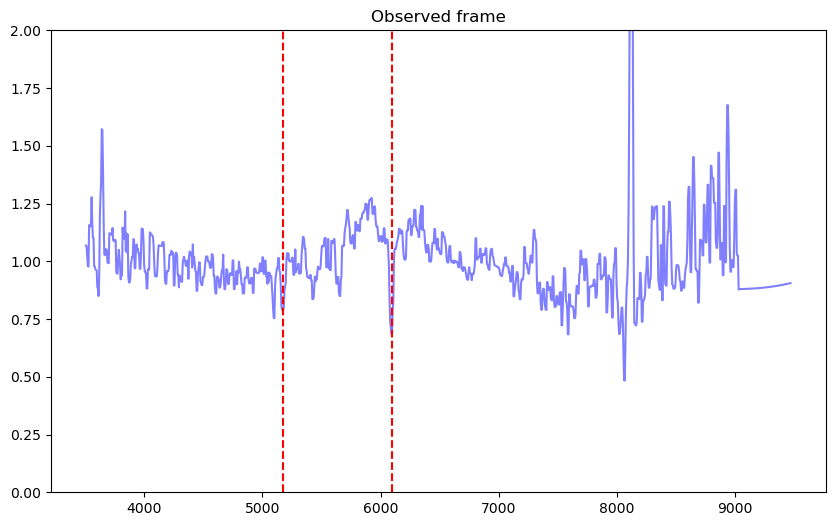

In [75]:
test_spec = get_spec1d("ud", test_fileindex, 
                       redshift[test_fileindex], bins = bins, 
                       quiet_fluxsigma = quiet_fluxsigma, fits_num = fits_num[test_fileindex])
test_continuum, popt, pcov, perr = get_continuum(test_spec, quiet_fluxsigma = quiet_fluxsigma)
test_spec_normalized = test_spec / test_continuum

import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(test_spec_normalized.spectral_axis.value, test_spec_normalized.flux.value, label='Normalized Spectrum', color='blue', alpha=0.5)

for line_name, line_center in detected_abs_lines.items():
    ax.axvline(x=line_center, color='red', linestyle='--', label=f'Detected: {line_name}')
    
ax.set_title("Observed frame")
ax.set_ylim(0, 2)
# ax.set_xlim(7000, 8000)

# Detection Summary

In [64]:
with pd.HDFStore("UltraDeep_Population_Profile.h5", mode='r') as store:
    absorption_table = store.get("AbsorptionLineDetection")  # Load the DataFrame from the HDF5 file
    print(f"""===== Loaded Table from HDF5 =====
>>> The table has been successfully loaded from 'UltraDeep_Population_Profile.h5' with the key 'AbsorptionLineDetection'.""")

line_names = list(known_line.keys())
counting_dict = {line_name: 0 for line_name in line_names}

for line in line_names:
    absorption_table[line] = absorption_table[line].apply(lambda x: 1 if x != 0 else 0)
    counting_dict[line] = absorption_table[line].sum()

absorption_table.loc[len(absorption_table)] = {"NUM": "Total Count", **counting_dict}

===== Loaded Table from HDF5 =====
>>> The table has been successfully loaded from 'UltraDeep_Population_Profile.h5' with the key 'AbsorptionLineDetection'.


In [70]:
summary = absorption_table.iloc[-1]  # Get the last row which contains the total counts
print(summary)

NUM                   Total Count
O VI λ1034                      6
Lyα λ1215                       6
N V λ1241                       0
O I λ1306                       0
C II λ1335                      8
Si IV λ1398                    14
Si IV + O IV λ1400             13
C IV λ1549                      6
He II λ1640                     0
O III λ1666                    20
Al III λ1857                    7
C III λ1909                     5
C II λ2326                     17
Ne IV λ2440                    18
Mg II λ2799                    26
Ne V λ3347                     12
Ne VI λ3427                     5
O II λ3727                      1
O II λ3730                      2
He I λ3889                      8
K λ3935                         5
H λ3970                        14
Hδ λ4103                        3
G λ4306                        13
Hγ λ4342                        4
O III λ4364                     6
Hβ λ4863                        4
O III λ4933                    10
O III λ4960   

In [71]:
# Find which row has non-zero Fe II 2374
fe_ii_2374_rows = absorption_table[absorption_table['Fe II λ2374'] != 0]
print(fe_ii_2374_rows)

             NUM  O VI λ1034  Lyα λ1215  N V λ1241  O I λ1306  C II λ1335  \
8      910174109           0          0          0          0           0   
12     910176723           0          0          0          0           0   
19     910181499           0          0          0          0           0   
22     910184163           0          0          0          0           1   
36     910198887           0          0          0          0           0   
42     910207451           0          0          0          0           0   
43     910207502           0          0          0          0           0   
54     910247358           0          0          0          0           0   
55     910247362           0          0          0          0           1   
56     910247604           0          0          0          0           0   
58     910249637           0          0          0          0           0   
60     910251317           0          0          0          0           0   

In [76]:
# Most commonly detected lines
most_common_lines = absorption_table.iloc[:-1].sum().sort_values(ascending=False)
print("Most commonly detected lines:")
print(most_common_lines)

Most commonly detected lines:
NUM                   135628526871
Fe II λ2374                     35
Fe II λ2344                     30
Mg II λ2799                     26
Fe II λ2600                     26
Fe II λ2586                     25
O III λ1666                     20
Ne IV λ2440                     18
C II λ2326                      17
H λ3970                         14
Si IV λ1398                     14
G λ4306                         13
Si IV + O IV λ1400              13
Ne V λ3347                      12
Mg λ5177                        11
O III λ4933                     10
S II λ6733                       8
N II λ6585                       8
He I λ3889                       8
C II λ1335                       8
Al III λ1857                     7
N I λ6529                        7
O III λ4364                      6
O I λ6366                        6
Lyα λ1215                        6
C IV λ1549                       6
O VI λ1034                       6
C III λ1909              